In [13]:
import torch as th
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [14]:
import einops
from einops import reduce, rearrange, einsum
import functools
from functools import partial
import time

In [15]:
device = th.device("cuda")

# Prepare Data

In [16]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [17]:
#dictionary:
#b'batch_label': b'training batch 1 of 5'
#b'labels': labels for each image
#b'data': image array
#b'filenames': filenames of the images
flattened_images = unpickle("./cifar-10-batches-py/data_batch_1")

In [18]:
#shape of flattened_images[b'data']: (batch_size, height*width*channels)

#input shape: (batch_size, height*width*channels)
def channelizeImages(flattened_images):
    #reshape to (batch_size, channels, height*width)
    images = rearrange(flattened_images[b'data'], 'b (c i) -> b c i', c=3, i=32*32)
    #reshape to (batch_size, channels, height, width)
    images = rearrange(images, 'b c (h w) -> b c h w', h=32, w=32)
    return images

In [19]:
images = channelizeImages(flattened_images)
images.shape

(10000, 3, 32, 32)

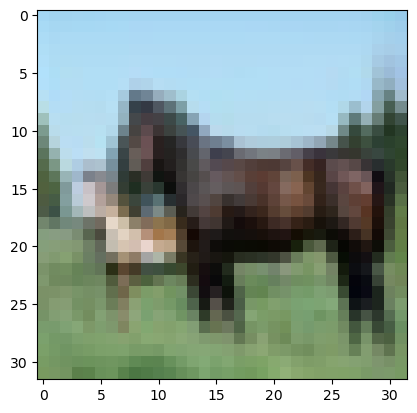

In [20]:
plt.imshow(rearrange(images[12,...], 'c h w -> h w c'))

In [21]:
class ImageDataset(Dataset):
    def __init__(self, data, sample_size):
        self.data = data
        self.sample_size = sample_size
    def __len__(self):
        return self.sample_size
    def __getitem__(self, idx):
        return self.data[idx]

In [22]:
type(images)

numpy.ndarray

# Diffusion Model

Noised image at time step $t$ is
$$q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\bar\alpha}x_0,(1-\bar \alpha_t)I),$$
$\alpha_t = 1-\beta_t$ and $\bar\alpha_t = \prod_{n=1}^t\alpha_n$

Image generation with
$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}}\epsilon_{\theta}(x_t,t)\right)+\sqrt{\beta_t}\epsilon.$$

## Components

### Position Embedding

It takes a batch of time and returns a batch of position embedding of the given dimension.

In [23]:
class SPositionalEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim//2
        N = 10000
        embeddings = math.log(N)/(half_dim-1)
        embeddings = th.exp(-th.arange(half_dim, device=device)*embeddings)
        embeddings = time[:, None]*embeddings[None, :]
        embeddings = th.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### UNet

#### Standardized Convolution

In [24]:
class WSConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eps = 1.e-5
    def forward(self, x):
        #mean and var are calculated over in_channel and kernel
        #note that the mean and var are not detached from autograd
        mean = reduce(self.weight, "o ... -> o 1 1 1", "mean")
        std = (reduce(self.weight, "o ... -> o 1 1 1", partial(th.var, unbiased=False)) + self.eps).sqrt()
        normalized_weight = (self.weight-mean)/std

        return F.conv2d(x, normalized_weight, bias=self.bias, stride=self.stride, padding=self.padding, groups=self.groups)

In [25]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1, groups=8):
        super().__init__()
        self.conv = WSConv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding)
        self.norm = nn.GroupNorm(groups, out_channel)
        self.act = nn.SiLU()
    def forward(self, x, emb=None):
        x = self.conv(x)
        x = self.norm(x)
        if emb is not None:
            x = x + emb
        return self.act(x)

#### Upsample

In [26]:
class Upsample(nn.Module):
    def __init__(self, in_channel, out_channel, scale_factor, padding=1):
        super().__init__()
        self.up = nn.Upsample(scale_factor=scale_factor, mode='nearest')
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=padding)
    def forward(self, x):
        x = self.up(x)
        return self.conv(x)

#### ResNet

Each resnet block consists of two standardized convolutions with a skip connection.

In [27]:
class ResNet(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1, time_emb_dim=None):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.time_emb_dim = time_emb_dim
        self.resnet_conv = nn.Conv2d(in_channel, out_channel, kernel_size=1, padding=0)
        self.conv1 = Conv2dBlock(in_channel, out_channel, kernel_size=kernel_size, padding=padding)
        self.conv2 = Conv2dBlock(out_channel, out_channel, kernel_size=kernel_size, padding=padding)
        self.mlp = (nn.Sequential(nn.SiLU(), nn.Linear(self.time_emb_dim, self.out_channel))
                    if time_emb_dim is not None else None)
            
    def forward(self, x, time_emb=None):
        #residual stream
        res = self.resnet_conv(x)
        #time embedding tensor
        if time_emb != None and self.mlp != None:
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
        #convolutions
        x = self.conv1(x, time_emb)
        x = self.conv2(x)
        return x + res

#### Attention

For a given batch of images with $C$ channels and $(h,w)$ image dimension, the attention block calculates image whose pixels are attention weighted sum over all pixels. The attention is calculated as follows.

The image dimension for each channel is flattented. The attention values are calculated between each query and key pixels with number of channels being the dimension of each pixel. The value pixels are summed weighted by the attention values. The image is unflattened.

In [28]:
class Attention(nn.Module):
    def __init__(self, in_channel, num_heads=4):
        super().__init__()
        self.in_channel = in_channel
        self.num_heads = num_heads
        self.qkv = nn.Conv2d(self.in_channel, self.in_channel*self.num_heads*3, kernel_size=1)
        self.out = nn.Conv2d(self.in_channel*self.num_heads, self.in_channel, kernel_size=1)
    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.qkv(x)
        qkv = rearrange(qkv, "b (hd c) h w -> b hd c (h w)", hd=self.num_heads)
        q, k, v = qkv.chunk(3, dim=2)

        #dimension of pixels is no of channels
        scale = 1/math.sqrt(self.in_channel)
        attn = einsum(q, k, "b hd c d1, b hd c d2 -> b hd d1 d2")*scale
        attn = attn.softmax(dim=-1)
        
        out = einsum(attn, v, "b hd d1 d2, b hd c d2 -> b hd c d1")
        out = rearrange(out, "b hd c (h1 w1) -> b (hd c) h1 w1", h1=h, w1=w)
        return self.out(out)

#### UNet Model

<div>
    <p style="display:inline-block; white-space:pre">Down stage:      $\xrightarrow[\text{dim}]{\text{c$_i$}}$InBlock $\xrightarrow[\text{dim}]{\text{c}}$ </p>
    <div style="border:1px solid white; display:inline-block; padding:5px;">
        ResBlock $\xrightarrow[\text{dim}]{\text{2c}}$ Down</div> 
    $\xrightarrow[\text{dim/2}]{\text{2c}}$ 
    <div style="border:1px solid white; display:inline-block; padding:5px;">
        ResBlock $\xrightarrow[\text{dim/2}]{\text{4c}}$ Down</div> 
    $\xrightarrow[\text{dim/4}]{\text{4c}}$
    <div style="border:1px solid white; display:inline-block; padding:5px;">
        ResBlock $\xrightarrow[\text{dim/4}]{\text{8c}}$ Down</div> 
    $\xrightarrow[\text{dim/8}]{\text{8c}}$
</div>
<div>
    <p style="display:inline-block; white-space:pre">
        Middle stage:      $\xrightarrow[\text{dim/8}]{\text{8c}}$</p>
    <div style="border:1px solid white; display:inline-block; padding:5px;">
        ResBlock</div> 
    $\xrightarrow[\text{dim/8}]{\text{16c}}$ 
</div>

<div>
    <p style="display:inline-block; white-space:pre">
        UP stage:      $\xrightarrow[\text{dim/8}]{\text{16c}}$</p>
    <div style="border:1px solid white; display:inline-block; padding:5px;">
        Up $\xrightarrow[\text{dim/4}]{\text{8c}}$ Cat $\xrightarrow[\text{dim/4}]{\text{16c}}$ ResBlock
    </div> 
    $\xrightarrow[\text{dim/4}]{\text{8c}}$
    <div style="border:1px solid white; display:inline-block; padding:5px;">
        Up $\xrightarrow[\text{dim/2}]{\text{4c}}$ Cat $\xrightarrow[\text{dim/2}]{\text{8c}}$ ResBlock
    </div> 
    $\xrightarrow[\text{dim/2}]{\text{4c}}$
    <div style="border:1px solid white; display:inline-block; padding:5px;">
        Up $\xrightarrow[\text{dim}]{\text{2c}}$ Cat $\xrightarrow[\text{dim}]{\text{4c}}$ ResBlock
    </div> 
    $\xrightarrow[\text{dim}]{\text{2c}}$
</div>
<br>
$\xrightarrow[\text{dim}]{\text{c}}$ Up $\xrightarrow[\text{2dim}]{\text{c/2}}\;=\;$ $\xrightarrow[\text{dim}]{\text{c}}$<div style="border:1px solid white; display:inline-block; padding:5px;">
            Upsample $\xrightarrow[\text{2dim}]{\text{c}}$ Conv2d</div>$\xrightarrow[\text{2dim}]{\text{c/2}}$

In [29]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channel, channels, time_emb_dim=None):
        super().__init__()
        self.in_channel = in_channel
        self.channels = channels
        
        #define the modules
        self.in_conv = nn.Conv2d(self.in_channel, self.channels[0], kernel_size=3, padding=1)
        self.down_stage = nn.ModuleList()
        self.mid_stage = nn.ModuleList()
        self.up_stage = nn.ModuleList()
        self.out_conv = nn.Conv2d(self.channels[1], self.in_channel, kernel_size=3, padding=1)
        
        #define the sequence of channels in the downstream and upstream
        self.down_channels = list(zip(self.channels[:-2], self.channels[1:-1]))
        self.up_channels = list(zip(reversed(self.channels[2:]), reversed(self.channels[1:-1])))
        
        #set up the downstream modules
        for in_ch, out_ch in self.down_channels:
            self.down_stage.append(nn.ModuleList([ResNet(in_ch, out_ch, time_emb_dim=time_emb_dim), ResNet(out_ch, out_ch, time_emb_dim=time_emb_dim),
                                                  Attention(out_ch),
                                                  nn.MaxPool2d(kernel_size=2, stride=2)]))
            
        #set up the middle stage module
        self.mid_stage.append(ResNet(self.channels[-2], self.channels[-1], time_emb_dim=time_emb_dim))
        self.mid_stage.append(Attention(self.channels[-1]))
        self.mid_stage.append(ResNet(self.channels[-1], self.channels[-1], time_emb_dim=time_emb_dim))
        
        #set up the upstream modules
        for in_ch, out_ch in self.up_channels:
            self.up_stage.append(nn.ModuleList([Upsample(in_ch, out_ch, scale_factor=2),
                                                ResNet(in_ch, out_ch, time_emb_dim=time_emb_dim), ResNet(out_ch, out_ch, time_emb_dim=time_emb_dim),
                                                Attention(out_ch)]))
            
        #setup the time embedding if time_emb is True
        self.time_emb_dim = time_emb_dim
        self.time_mlp = (nn.Sequential(SPositionalEmbeddings(self.time_emb_dim),
                                       nn.SiLU(), nn.Linear(self.time_emb_dim, self.time_emb_dim)) if self.time_emb_dim else None)
    
    def forward(self, x, time_level=None):
        #time embedding
        time_emb = self.time_mlp(time_level) if self.time_mlp != None and time_level != None else None
        #initial convolution
        x = self.in_conv(x)
        resnet = []
        #sequence of downsampling
        for block1, block2, attn, down in self.down_stage:
            x = block1(x, time_emb)
            resnet.append(x)
            x = block2(x, time_emb)
            x = x + attn(x)
            x = down(x)
        #mid layer
        #ResNet
        x = self.mid_stage[0](x, time_emb)
        #Attention
        x = x + self.mid_stage[1](x)
        #ResNet
        x = self.mid_stage[2](x, time_emb)
        #sequence of upsampling
        for up, block1, block2, attn in self.up_stage:
            x = up(x)
            x = th.cat((x, resnet.pop()), dim=1)
            x = block1(x, time_emb)
            x = block2(x, time_emb)
            x = x + attn(x)
        #final convolution
        x = self.out_conv(x)
        return x
    @th.no_grad()
    def predict(self, x):
        return self(x)

## Model

In [30]:
class VanillaDiffusion(th.nn.Module):
    def __init__(self, in_channel, channels, time_emb_dim=32, time_steps=100, device="cpu"):
        super().__init__()
        self.in_channel = in_channel
        self.channels = channels
        self.time_emb_dim = time_emb_dim
        self.device = device
        
        self.scheduleSetup(time_steps)
        self.attn_unet = AttentionUNet(self.in_channel, self.channels, self.time_emb_dim)
    
    def forward(self, x, noise_levels):
        return self.attn_unet(x, noise_levels)  
    
    @th.no_grad()
    def generate(self, num_samples, dim=32):
        x = th.randn((num_samples, self.in_channel, dim, dim), device=self.device)
        
        for time in reversed(range(1, self.timesteps+1)):
            noise_level = th.full((num_samples,), time, device=self.device)
            pred_noise = self(x, noise_level)
            z = th.randn((num_samples, 1, 1, 1), device=self.device) if time>1 else 0
            x = ((x - (1-self.alphas[time-1])/(1-self.alphas_cumprod[time-1]).sqrt() * pred_noise)/self.alphas[time-1].sqrt()
                 + self.betas[time-1].sqrt()*z)
        return x
        
    def linearBetaSchedule(self, timesteps):
        beta_start = 0.0001
        beta_end = 0.02
        return th.linspace(beta_start, beta_end, timesteps)

    #takes a mini batch of a number of channels of input image,
    #adds noise at the level t
    #t - mini batch of noise levels
    def qSample(self, x_start, t, noise=None):
        if noise is None:
            th.randn(x_start.shape, device=self.device)
        mu_t = rearrange(self.means[t], 'a -> a 1 1 1')
        sigma_t = rearrange(self.sigmas[t], 'a -> a 1 1 1')
        return mu_t*x_start + sigma_t*noise

    def loss(self, added_noise, pred_noise):
        return (added_noise-pred_noise).square().mean()

    def setup(self, batch_size, epochs, lr=1.e-3):
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.optimizer = th.optim.Adam(self.parameters(), lr=self.lr)
    
    def scheduleSetup(self, timesteps):
        self.timesteps = timesteps
        self.betas = self.linearBetaSchedule(self.timesteps).to(self.device)
        self.alphas = (1-self.betas).sqrt()
        self.betas = self.betas.sqrt()
        self.alphas_cumprod = th.cumprod(self.alphas, axis=0)
        self.means = self.alphas_cumprod.sqrt()
        self.sigmas = (1-self.alphas_cumprod).sqrt()
    
    def trainStep(self, dataset):
        start_time = time.time()
        data_loader = DataLoader(dataset, self.batch_size, shuffle=True)
        history = []
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}")
            self.train()
            for images in data_loader:
                images = images.to(self.device)
                added_noise = th.randn(images.shape, device=self.device)
                noise_levels = th.randint(1, self.timesteps+1, (self.batch_size,), device=self.device)
                noised_images = self.qSample(images, noise_levels-1, added_noise)
                pred_noise = self(noised_images, noise_levels)
                loss = self.loss(added_noise, pred_noise)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            history.append(loss.cpu())
        end_time = time.time()
        print("Done!")
        print(f"Training time: {(end_time - start_time)} sec")
        return history

## Train

In [31]:
sample_size = len(images)
batch_size = 20
epochs = 10
lr = 1.e-3

dataset = ImageDataset(images, sample_size)

In [32]:
in_channel = 3
channels = [32, 64, 128]
time_emb_dim = 32
time_steps = 300

diffusion_model = VanillaDiffusion(in_channel, channels, time_emb_dim=time_emb_dim, time_steps=time_steps, device='cuda')
diffusion_model.setup(batch_size, epochs, lr)
diffusion_model = diffusion_model.cuda()

In [33]:
history = diffusion_model.trainStep(dataset)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Done!
Training time: 980.5416893959045 sec


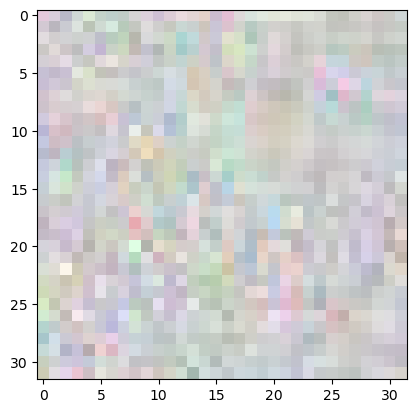

In [43]:
img = diffusion_model.generate(1)
img = rearrange(img.squeeze(), "c h w -> h w c").cpu().numpy()
max_val = abs(img).max()
plt.imshow(img/max_val)